In [1]:
import json
import re 
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd 
from collections import Counter, defaultdict
from scipy import stats

from calibration_metric.vis.calibration_plot import plot_df
from calibration_metric.metric import ECEMetric

plt.rcParams["font.family"] = "Nimbus Roman"

from calibration_utils import (read_nucleus_file, 
                                read_gold_file,get_probs_and_accs, 
                                read_benchclamp_file, 
                                get_probs_and_accs_benchclamp,
                                get_probs_and_accs_sql,
                                get_accs_sql)

/brtx/601-nvme1/estengel/miniconda3/envs/bclamp2/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:


bart_data = read_benchclamp_file("/brtx/602-nvme1/estengel/calflow_calibration/benchclamp/logs/1.0/bart-large_spider_past_none_db_val_all_0.0001_5000_test_eval_unconstrained-beam_bs_5/model_outputs.20230208T031316.jsonl")
# bart_min_probs, bart_mean_probs, bart_accs = get_probs_and_accs_benchclamp(bart_data) 
spider_gold_path = "/brtx/601-nvme1/estengel/resources/data/benchclamp/processed/Spider/test_all.jsonl"
bart_min_probs, bart_mean_probs, bart_exact_accs = get_probs_and_accs_benchclamp(bart_data) # , spider_gold_path) 

t5_data = read_benchclamp_file("/brtx/602-nvme1/estengel/calflow_calibration/benchclamp/logs/1.0/t5-base-lm-adapt_spider_past_none_db_val_all_0.0001_10000_test_eval_unconstrained-beam_bs_5/model_outputs.20230206T093954.jsonl") 
# t5_min_probs, t5_mean_probs, t5_accs = get_probs_and_accs_benchclamp(t5_data)
t5_min_probs, t5_mean_probs, t5_exact_accs = get_probs_and_accs_benchclamp(t5_data) #, spider_gold_path)

/home/estengel/calibration_metric/calibration_metric/utils/warnings.py:12: RuntimeWarning: Metric Weighted ECE has less than 3 active bins
  warnings.warn(f"Metric {metric_name} has less than 3 active bins", RuntimeWarning)


getting sql execution accuracy for each bin
replacing exact match accuracy with execution accuracy...
getting sql execution accuracy for each bin
replacing exact match accuracy with execution accuracy...


/home/estengel/calibration_metric/calibration_metric/utils/warnings.py:12: RuntimeWarning: Metric Weighted ECE has less than 3 active bins
  warnings.warn(f"Metric {metric_name} has less than 3 active bins", RuntimeWarning)


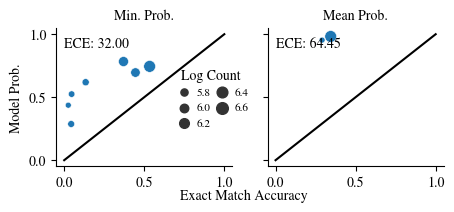

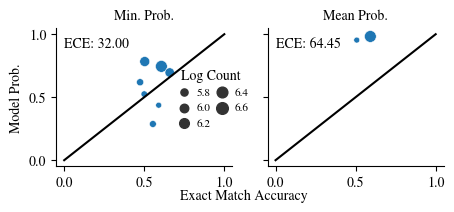

In [5]:


def comparison_plot(min_probs, mean_probs, accs, path, use_exact_match, bclamp_data, gold_path, n_bins = 10, binning_strategy='uniform'):
    ece_metric = ECEMetric(n_bins=n_bins, binning_strategy=binning_strategy)
    if binning_strategy == "uniform":
        (min_values, 
        min_bins, 
        min_bin_number) = ece_metric.uniform_bin(min_probs, accs)
    else:
        (min_values, 
        min_bins, 
        min_bin_number) = ece_metric.adaptive_bin(min_probs, accs)

    if not use_exact_match:
        # convert exact match accuracy to evaluation accuracy
        print(f"getting sql execution accuracy for each bin")
        min_execution_accs = get_accs_sql(bclamp_data, gold_path, min_bin_number) 
        print(f"replacing exact match accuracy with execution accuracy...")
        min_values = [min_execution_accs[bin] for bin in range(len(min_values))]
        # replace the accuracies with copies of the average for computing the ECE on the eval match accuracy
        min_accs = [min_execution_accs[bin] for bin in min_bin_number]
        min_ece = ece_metric(np.array(min_probs), np.array(min_accs))
    else:
        min_ece = ece_metric(np.array(min_probs), np.array(accs))

    min_df_to_plot = ece_metric.bins_to_df(min_values, min_bins, min_bin_number)
    min_ece *= 100

    if binning_strategy == "uniform":
        (mean_values, 
        mean_bins, 
        mean_bin_number) = ece_metric.uniform_bin(mean_probs, accs)
    else:
        (mean_values, 
        mean_bins, 
        mean_bin_number) = ece_metric.adaptive_bin(mean_probs, accs)

    if not use_exact_match:
        print(f"getting sql execution accuracy for each bin")
        mean_execution_accs = get_accs_sql(bclamp_data, gold_path, mean_bin_number)
        print(f"replacing exact match accuracy with execution accuracy...")
        mean_values = [mean_execution_accs[bin] for bin in range(len(mean_values))]
        mean_accs = [mean_execution_accs[bin] for bin in mean_bin_number]
        mean_ece = ece_metric(np.array(mean_probs), np.array(mean_accs))
    else:
        mean_ece = ece_metric(np.array(mean_probs), np.array(accs))

    mean_df_to_plot = ece_metric.bins_to_df(mean_values, mean_bins, mean_bin_number)
    mean_ece *= 100

    fig, ax = plt.subplots(1,2, figsize=(5,1.8), sharex=True, sharey=True)
    metric_kwargs = {"x": 0.000, "y": 0.9, "fontsize": 10, "horizontalalignment": "left"}

    ax[0].set_title("Min. Prob.", fontsize=10)
    ax[1].set_title("Mean Prob.", fontsize=10)
    plot = plot_df(min_df_to_plot, 
                   ylabel="Model Prob.", 
                   xlabel=None, 
                   ax = ax[0], 
                   show_legend=False, 
                   metric_value=min_ece, 
                   metric_value_kwargs = metric_kwargs)
    plot = plot_df(mean_df_to_plot, 
                   ylabel="Model Prob.", 
                   xlabel=None, 
                   ax=ax[1], 
                   show_legend=False, 
                   metric_value=mean_ece, 
                   metric_value_kwargs=metric_kwargs) 
    # ax[0].set_xlabel("EM Accuracy", fontsize=10) # , bbox = {"xy": (0.7,0.0)})
    fig.text(0.5, -0.05, "Exact Match Accuracy", ha="center", va="center", fontsize=10)

    handles, labels = plt.gca().get_legend_handles_labels()
    fig.legend(handles, labels, fontsize=8, ncol=2, title="Log Count", frameon=False, bbox_to_anchor=(0.53, 0.71), handletextpad=0.1, columnspacing=0.1)

    # plt.tight_layout()
    # plt.savefig("/home/estengel/papers/did-you-mean-2022/figures/seq_calibration.pdf", bbox_inches='tight')
    if path is not None:
        plt.savefig(path, bbox_inches='tight')
    return min_values, min_bins, min_bin_number


exact_bart_values, exact_bart_bins, exact_bart_bin_number = comparison_plot(bart_min_probs, 
                                                          bart_mean_probs, 
                                                          bart_exact_accs, 
                                                          None, 
                                                          use_exact_match=True,
                                                          bclamp_data=bart_data,
                                                          gold_path=spider_gold_path,
                                                          n_bins=10, 
                                                          binning_strategy='adaptive')

eval_bart_values, eval_bart_bins, eval_bart_bin_number = comparison_plot(bart_min_probs, 
                                                          bart_mean_probs, 
                                                          bart_exact_accs, 
                                                          None, 
                                                          use_exact_match=False,
                                                          bclamp_data=bart_data,
                                                          gold_path=spider_gold_path,
                                                          n_bins=10, 
                                                          binning_strategy='adaptive')
# t5_values, t5_bins, t5_bin_number = comparison_plot(t5_min_probs, 
#                                                     t5_mean_probs, 
#                                                     t5_accs, 
#                                                     None, 
#                                                     bclamp_data=t5_data,
#                                                     gold_path=spider_gold_path,
#                                                     n_bins=10, 
#                                                     binning_strategy='adaptive')